### Importing required libraries

In [49]:
# Data manipulation and analysis
import numpy as np 
import pandas as pd 

# Data visualization
import matplotlib.pyplot as plt 
import seaborn as sns

# Stock market data
import yfinance as yf

# Deep learning (PyTorch)
import torch
import torch.nn as nn 
import torch.optim as optim

# Data preprocessing and evaluation
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import root_mean_squared_error

### Set device to GPU if available, else CPU

In [50]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Download historical stock data for Apple (AAPL) starting from Jan 1, 2020

In [51]:
ticker = 'MSFT'
df_stock = yf.download(ticker, '2020-01-01', auto_adjust=False)
df_stock

[*********************100%***********************]  1 of 1 completed


Price        Adj Close       Close        High         Low        Open  \
Ticker            MSFT        MSFT        MSFT        MSFT        MSFT   
Date                                                                     
2020-01-02  152.791092  160.619995  160.729996  158.330002  158.779999   
2020-01-03  150.888596  158.619995  159.949997  158.059998  158.320007   
2020-01-06  151.278625  159.029999  159.100006  156.509995  157.080002   
2020-01-07  149.899307  157.580002  159.669998  157.320007  159.320007   
2020-01-08  152.286972  160.089996  160.800003  157.949997  158.929993   
...                ...         ...         ...         ...         ...   
2025-08-20  504.890015  505.720001  511.000000  504.440002  509.869995   
2025-08-21  504.239990  504.239990  507.630005  502.720001  503.690002   
2025-08-22  507.230011  507.230011  510.730011  502.410004  504.250000   
2025-08-25  504.260010  504.260010  508.190002  504.119995  506.630005   
2025-08-26  502.040009  502.040009  504.977814  498.510010  504.355011   

Price         Volume  
Ticker          MSFT  
Date                  
2020-01-02  22622100  
2020-01-03  21116200  
2020-01-06  20813700  
2020-01-07  21634100  
2020-01-08  27746500  
...              ...  
2025-08-20  27723000  
2025-08-21  18443300  
2025-08-22  24324200  
2025-08-25  21638600  
2025-08-26  30265956  

[1420 rows x 6 columns]

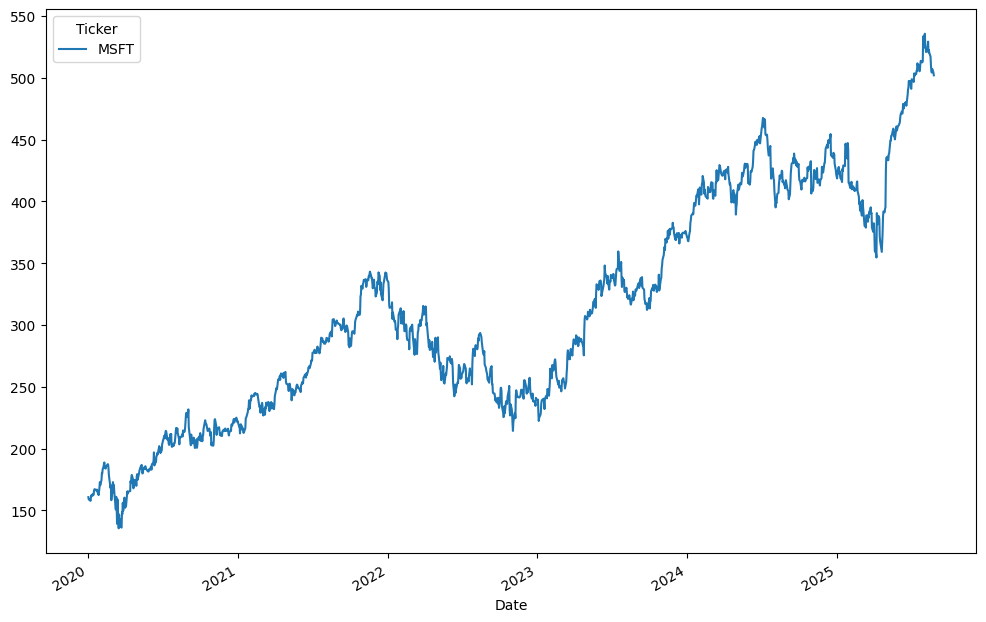

In [52]:
df_stock.Close.plot(figsize=(12,8))
plt.show()

In [53]:
scaler = StandardScaler()
df_stock['Close'] = scaler.fit_transform(df_stock['Close'])
df_stock['Close']

Ticker          MSFT
Date                
2020-01-02 -1.661920
2020-01-03 -1.683971
2020-01-06 -1.679451
2020-01-07 -1.695438
2020-01-08 -1.667764
...              ...
2025-08-20  2.142983
2025-08-21  2.126665
2025-08-22  2.159632
2025-08-25  2.126886
2025-08-26  2.102409

[1420 rows x 1 columns]

##### Based on the past stock data, we try to predict future stock price

In [54]:
# sequence_length denotes how many past days we use to predict the next day
sequence_length = 30

data = []

for index in range(len(df_stock) - sequence_length):
    data.append(df_stock.Close[index:index+sequence_length])

data = np.array(data)

In [55]:
training_size = int(0.8 * len(data))

X_train = torch.from_numpy(data[:training_size, :-1, :]).type(torch.Tensor).to(device)
y_train = torch.from_numpy(data[:training_size, -1, :]).type(torch.Tensor).to(device)
X_test = torch.from_numpy(data[training_size:, :-1, :]).type(torch.Tensor).to(device)
y_test = torch.from_numpy(data[training_size:, -1, :]).type(torch.Tensor).to(device)

In [56]:
# LSTM-based model for sequence prediction
class LSTMPredictor(nn.Module):  # Inherit from PyTorch base module
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMPredictor, self).__init__()

        self.num_layers = num_layers
        self.hidden_size = hidden_size

        # LSTM layer: input_size -> hidden_size, stacked num_layers times
        # batch_first=True: input shape is (batch, sequence_length, features)
        # dropout applies between LSTM layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=0.2)
        
        # Fully connected layer to map last hidden state to output
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        batch_size = x.size(0)

        # Initialize hidden state and cell state with zeros
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size, device=device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size, device=device)

        # Pass input through LSTM
        lstm_out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        # Use the last time step's output for final prediction
        predictions = self.fc(lstm_out[:, -1, :])

        return predictions

In [57]:
model = LSTMPredictor(input_size=1, hidden_size=32, num_layers=2, output_size=1).to(device)

In [58]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [59]:
# Set number of training epochs
num_epochs = 200

# Training loop
for epoch in range(num_epochs):
    # Forward pass: predict outputs for training data
    y_train_pred = model(X_train)

    # Compute loss between predictions and true values
    loss = criterion(y_train_pred, y_train)

    # Print loss every 25 epochs to monitor training
    if epoch % 25 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")

    # Zero gradients from previous step
    optimizer.zero_grad()

    # Backpropagate to compute gradients
    loss.backward()

    # Update model parameters
    optimizer.step()

Epoch 0, Loss: 0.6324166655540466
Epoch 25, Loss: 0.014979235827922821
Epoch 50, Loss: 0.008023232221603394
Epoch 75, Loss: 0.0067986189387738705
Epoch 100, Loss: 0.006579206790775061
Epoch 125, Loss: 0.005922494921833277
Epoch 150, Loss: 0.005681740120053291
Epoch 175, Loss: 0.005350562743842602


In [60]:
model.eval()

y_test_pred = model(X_test)

y_train_pred = scaler.inverse_transform(y_train_pred.detach().cpu().numpy())
y_train = scaler.inverse_transform(y_train.detach().cpu().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().cpu().numpy())
y_test = scaler.inverse_transform(y_test.detach().cpu().numpy())

In [61]:
train_rmse = root_mean_squared_error(y_train[:, 0], y_train_pred[:, 0])
test_rmse = root_mean_squared_error(y_test[:, 0], y_test_pred[:, 0])

In [62]:
train_rmse, test_rmse

(6.35614538192749, 12.31939697265625)

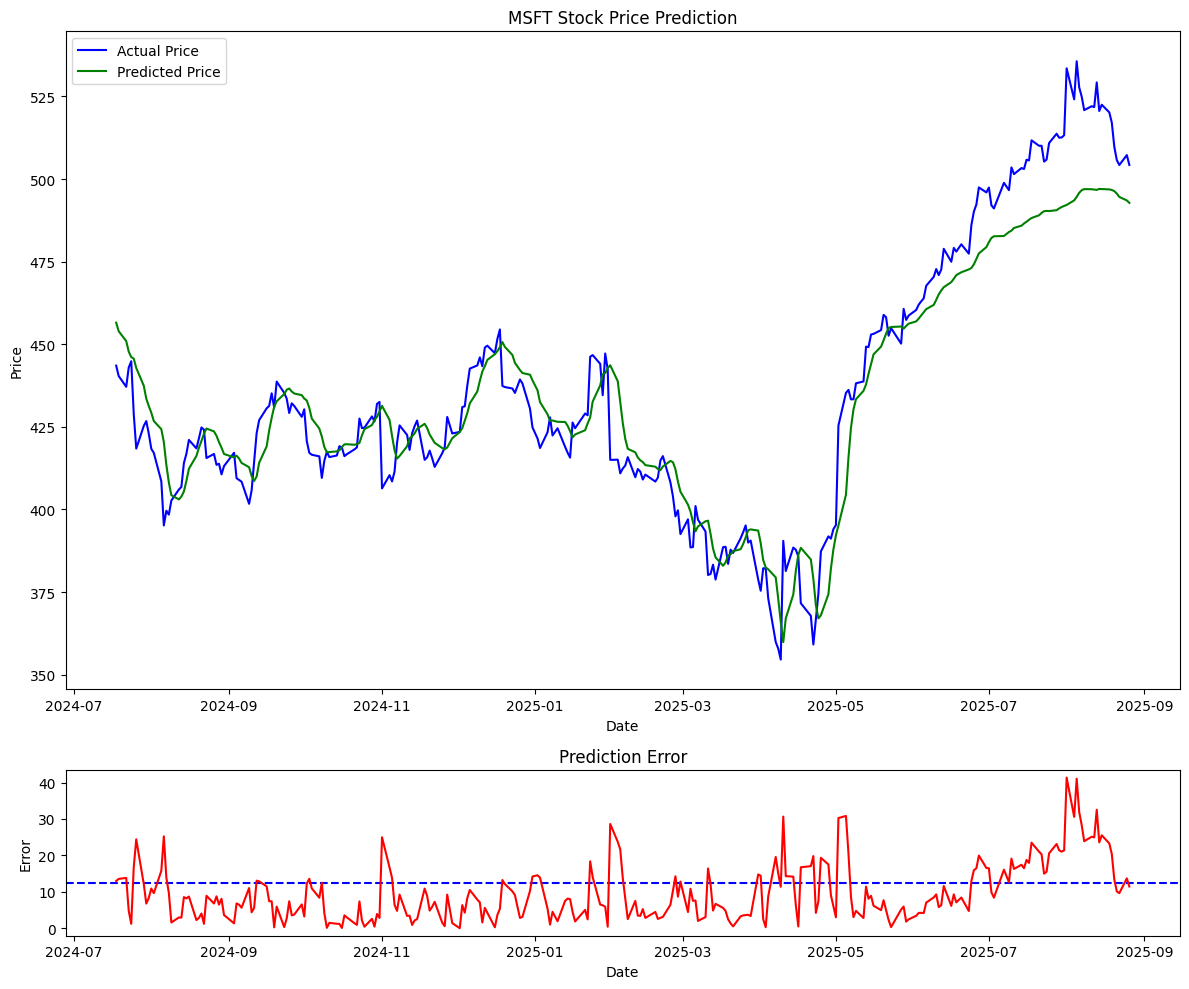

In [63]:
figure = plt.figure(figsize=(12,10))
grid_spec = figure.add_gridspec(4,1)

axis_1 = figure.add_subplot(grid_spec[:3,0])
axis_1.plot(df_stock.iloc[-len(y_test):].index, y_test, color = 'blue', label = 'Actual Price')
axis_1.plot(df_stock.iloc[-len(y_test):].index, y_test_pred, color = 'green', label = 'Predicted Price')
axis_1.legend()
plt.title(f"{ticker} Stock Price Prediction")
plt.xlabel('Date')
plt.ylabel('Price')

axis_2 = figure.add_subplot(grid_spec[3,0])
axis_2.axhline(test_rmse, color='blue', linestyle='--', label='RMSE')
axis_2.plot(df_stock.iloc[-len(y_test):].index, abs(y_test - y_test_pred), color = 'red', label = 'Prediction Error')
axis_1.legend()
plt.title("Prediction Error")
plt.xlabel('Date')
plt.ylabel('Error')
plt.tight_layout()

plt.show()